In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cx_Oracle as cxo
import getpass as gp

%matplotlib inline

### Create an EDW connection  

In [4]:
conn = cxo.connect(user=gp.getuser(),password=gp.getpass("EDW passord: "),dsn="edw.co.ihc.com",encoding="UTF-8")

EDW passord: ········


In [78]:
query = """select height, weight 
            from cerner_dm.med_admin 
            where 1 = 1
                and height is not null 
                and height > 1
                and height < 3
                and weight is not null 
                and weight < 400
                and admit_age_yrs >= 18
                and rownum < 50000"""
#there are some errors in this data set, hence all of the WHERE clauses....

### Pull height and weight into a dataframe  

In [79]:
BMI_df = pd.read_sql(query, con = conn)

In [80]:
BMI_df.head()

,HEIGHT,WEIGHT
0,1.650,73.9
1,1.570,89.8
2,1.778,160.2
3,1.527,65.3
4,1.530,98.2


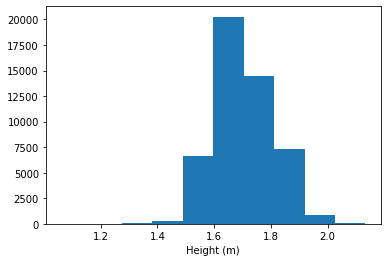

In [81]:
plt.hist(BMI_df.HEIGHT)
plt.xlabel('Height (m)')
plt.show()

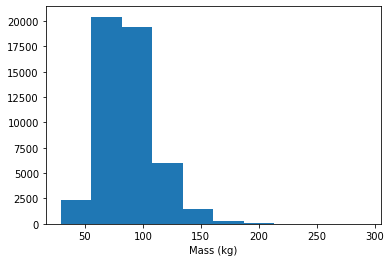

In [82]:
plt.hist(BMI_df.WEIGHT)
plt.xlabel('Mass (kg)')
plt.show()

### Calulate BMI:

In [83]:
Y = np.divide(BMI_df.WEIGHT, np.square(BMI_df.HEIGHT))

In [84]:
Y.max() #clearly an error, but this is deterministic, so not a big deal....

142.53269637403088

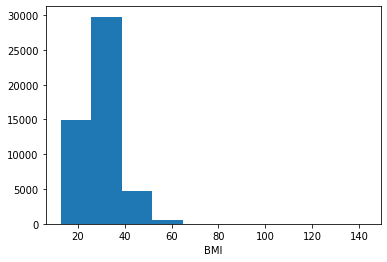

In [85]:
plt.hist(Y)
plt.xlabel('BMI')
plt.show()

define R-squared for keras:

In [86]:
def R_Squared(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Create/run the model:

In [94]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu,input_shape = (2,)))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics=[R_Squared])

model.fit(BMI_df,Y,batch_size = 32,epochs = 15)

Epoch 1/15
49999/49999 [==============================] - 2s 33us/sample - loss: 100.5099 - R_Squared: -1.2877
Epoch 2/15
49999/49999 [==============================] - 2s 32us/sample - loss: 14.0507 - R_Squared: 0.6835
Epoch 3/15
49999/49999 [==============================] - 2s 33us/sample - loss: 13.6804 - R_Squared: 0.6912
Epoch 4/15
49999/49999 [==============================] - 2s 31us/sample - loss: 13.2394 - R_Squared: 0.7030
Epoch 5/15
49999/49999 [==============================] - 2s 32us/sample - loss: 12.9134 - R_Squared: 0.7090
Epoch 6/15
49999/49999 [==============================] - 2s 31us/sample - loss: 12.6031 - R_Squared: 0.7183
Epoch 7/15
49999/49999 [==============================] - 2s 32us/sample - loss: 12.3417 - R_Squared: 0.7253
Epoch 8/15
49999/49999 [==============================] - 2s 33us/sample - loss: 12.0726 - R_Squared: 0.7333
Epoch 9/15
49999/49999 [==============================] - 2s 32us/sample - loss: 11.7398 - R_Squared: 0.7415
Epoch 10/15
49999

The final R-Squared varies from run to run, but is typlically close to 98%--a near perfect prediction.

## Sligthtly Different Example  

### Create a bunch of random variables

In [100]:
n_obs = BMI_df.shape[0] #number of observations to simulate

In [111]:
rand_norm = np.random.randn(n_obs)

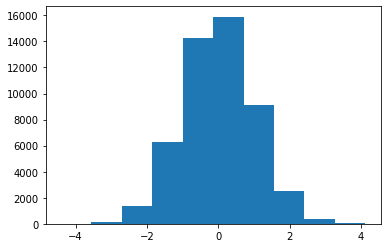

In [112]:
plt.hist(rand_norm)
plt.show()

In [109]:
rand_unif = rand_norm = np.random.rand(n_obs)

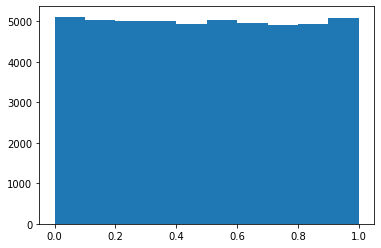

In [113]:
plt.hist(rand_unif)
plt.show()

In [122]:
rand_beta1 = rand_norm = np.random.beta(2,5,n_obs)

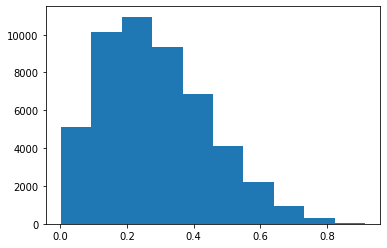

In [116]:
plt.hist(rand_beta1)
plt.show()

In [117]:
rand_beta2 = rand_norm = np.random.beta(5,2,n_obs)

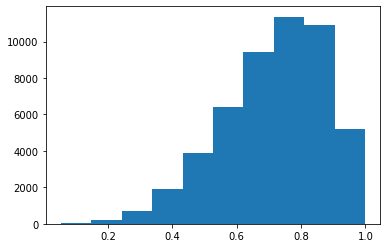

In [119]:
plt.hist(rand_beta2)
plt.show()

In [137]:
random_cols = pd.DataFrame(np.column_stack((rand_norm,rand_unif,rand_beta1,rand_beta2)))

In [138]:
random_cols.head()

,0,1,2,3
0,0.679806,0.364068,0.679806,0.671993
1,0.053658,0.178234,0.053658,0.743777
2,0.209401,0.300625,0.209401,0.677793
3,0.270386,0.353318,0.270386,0.845811
4,0.512726,0.467280,0.512726,0.787724


### Append these new varaibles to the previous data

In [147]:
new_df = pd.concat((BMI_df,random_cols),axis=1)

In [148]:
new_df.head()

,HEIGHT,WEIGHT,0,1,2,3
0,1.650,73.9,0.679806,0.364068,0.679806,0.671993
1,1.570,89.8,0.053658,0.178234,0.053658,0.743777
2,1.778,160.2,0.209401,0.300625,0.209401,0.677793
3,1.527,65.3,0.270386,0.353318,0.270386,0.845811
4,1.530,98.2,0.512726,0.467280,0.512726,0.787724


### re-run the same model

In [151]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu,input_shape = (6,)))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics=[R_Squared])

model.fit(new_df,Y,batch_size = 32,epochs = 15)

Epoch 1/15
49999/49999 [==============================] - 2s 34us/sample - loss: 44.7894 - R_Squared: 0.0188
Epoch 2/15
49999/49999 [==============================] - 2s 32us/sample - loss: 13.3919 - R_Squared: 0.6961
Epoch 3/15
49999/49999 [==============================] - 2s 32us/sample - loss: 12.9088 - R_Squared: 0.7116
Epoch 4/15
49999/49999 [==============================] - 2s 32us/sample - loss: 12.6346 - R_Squared: 0.7204
Epoch 5/15
49999/49999 [==============================] - 2s 33us/sample - loss: 12.1936 - R_Squared: 0.7301
Epoch 6/15
49999/49999 [==============================] - 2s 36us/sample - loss: 11.6552 - R_Squared: 0.7410
Epoch 7/15
49999/49999 [==============================] - 2s 35us/sample - loss: 10.3169 - R_Squared: 0.7718
Epoch 8/15
49999/49999 [==============================] - 2s 32us/sample - loss: 7.3327 - R_Squared: 0.8406
Epoch 9/15
49999/49999 [==============================] - 2s 32us/sample - loss: 3.2162 - R_Squared: 0.9332
Epoch 10/15
49999/499

The performance is the same--despite the presence of variables that add no value.
It is still able to create a facsimile of a transformation!